

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_df   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_path = '/content/drive/MyDrive/프로젝트 마켓컬리/products_price_predict-main 2/data/raw'
processed_path = '/content/drive/MyDrive/프로젝트 마켓컬리/products_price_predict-main 2/data/processed'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,576 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [4]:
import seaborn as sns
plt.rc('font', family='NanumGothic')
plt.rcParams['figure.figsize'] = (26, 16)

In [5]:
# tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'/grape.csv')
shinemuscat = pd.read_csv(processed_path+'/shinemuscat.csv')
bigpa = pd.read_csv('/content/drive/MyDrive/프로젝트 마켓컬리/데이터/raw 2/대파 Final.csv')
sang = pd.read_csv('/content/drive/MyDrive/프로젝트 마켓컬리/데이터/raw 2/ㅜ대/깻잎(합친거).csv')
tomato = pd.read_csv('/content/drive/MyDrive/프로젝트 마켓컬리/데이터/raw 2/ㅜ대/토마토(합친거).csv')




train = pd.read_csv(raw_path+'/train.csv')
test = pd.read_csv(raw_path+'/test.csv')
private = pd.read_csv(raw_path+'/private_data.csv')
submission = pd.read_csv(raw_path+'/sample_submission.csv')


print(train.shape)
print(test.shape)
print(private.shape)
print(submission.shape)

(1733, 44)
(37, 44)
(291, 44)
(228, 22)


In [6]:
계절 = pd.read_csv('/content/drive/MyDrive/프로젝트 마켓컬리/데이터/계절.csv')

In [7]:
# 0 : 겨울(12~2월) // 1 : 봄(3~5월) // 2: 여름(6~8월) // 3: 가을(9~11월)
start = 계절[:1733]
first = start.replace({'계절':{'겨울':0}})
second = first.replace({'계절':{'봄':1}})
third = second.replace({'계절':{'여름':2}})
fourth = third.replace({'계절':{'가을':3}})
season = fourth.drop('Unnamed: 0', axis=1)
season

계절
0      0
1      0
2      0
3      0
4      0
...   ..
1728   3
1729   3
1730   3
1731   3
1732   3

[1733 rows x 1 columns]

In [43]:
df = pd.concat([train,test]).reset_index(drop=True)
grape_df = df[['date','요일','캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)' ]]
shinemuscat_df = df[['date','요일', '샤인마스캇_거래량(kg)', '샤인마스캇_가격(원/kg)']]
bigpa_df = df[['date','요일','대파_거래량(kg)', '대파_가격(원/kg)' ]]
tomato_df = df[['date','요일', '토마토_거래량(kg)', '토마토_가격(원/kg)']]
sang_df = df[['date','요일','깻잎_거래량(kg)', '깻잎_가격(원/kg)' ]]


# 1주전 , 2주전 + 계절 코드 (태성님)




In [90]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 걍 그 날 가격으로 합니다.
A = [];B = []
for x in range(10):
    A.append(shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[x])
    B.append(shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[x])
for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    if s != 0:
        for w in range(7):
            A.append(s / (7 - v_1))
            B.append(t / (7 - v_2))
    else:
        for w in range(7):
            A.append(0)
            B.append(0)
for z in range(7):
    s += shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[1725 + z]
    t += shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[1725 + z]
v_1 = (shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[1725:1732] == 0).sum()
if s != 0:
    A.append(s / (7 - v_1))
    B.append(t / (7 - v_2))
else:
    A.append(0)
    B.append(0)
Adf = pd.DataFrame(A, columns = ['샤인마스캇_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['샤인마스캇_가격의_1주전_평균'])

# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 걍 그 날 가격으로 합니다.
C = [];D = []
for x in range(17):
    C.append(shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[x])
    D.append(shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[x])
for y in range(245):
    p = 0;q = 0
    for z in range(14):
        p += shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[(y * 7) + z + 3]
        q += shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    if p != 0:
        for w in range(7):
            C.append(p / (14 - v_1))
            D.append(q / (14 - v_2))
    else:
        for w in range(7):
            C.append(0)
            D.append(0)
for z in range(14):
    p += shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[1718 + z]
    q += shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[1718 + z]
v_1 = (shinemuscat_df['샤인마스캇_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (shinemuscat_df['샤인마스캇_가격(원/kg)'].iloc[1718:1732] == 0).sum()
if p != 0:
    C.append(p / (14 - v_1))
    D.append(q / (14 - v_2))
else:
    C.append(0)
    D.append(0)
Cdf = pd.DataFrame(C, columns = ['샤인마스캇_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['샤인마스캇_가격의_2주전_평균'])

새로운샤인마스캇 = pd.concat([shinemuscat_df, Adf, Bdf, Cdf, Ddf, season], axis=1)
새로운샤인마스캇

date   요일  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)  샤인마스캇_거래량의_1주전_평균  \
0     2016-01-01  금요일            0.0             0.0                0.0   
1     2016-01-02  토요일            0.0             0.0                0.0   
2     2016-01-03  일요일            0.0             0.0                0.0   
3     2016-01-04  월요일            0.0             0.0                0.0   
4     2016-01-05  화요일            0.0             0.0                0.0   
...          ...  ...            ...             ...                ...   
1765  2020-10-31  토요일       111721.4          9735.0                NaN   
1766  2020-11-01  일요일            0.0             0.0                NaN   
1767  2020-11-02  월요일        88354.3         10205.0                NaN   
1768  2020-11-03  화요일        84795.0         10322.0                NaN   
1769  2020-11-04  수요일        74970.5         10178.0                NaN   

      샤인마스캇_가격의_1주전_평균  샤인마스캇_거래량의_2주전_평균  샤인마스캇_가격의_2주전_평균   계절  
0                  0.0                0.0               0.0  0.0  
1                  0.0                0.0               0.0  0.0  
2                  0.0                0.0               0.0  0.0  
3                  0.0                0.0               0.0  0.0  
4                  0.0                0.0               0.0  0.0  
...                ...                ...               ...  ...  
1765               NaN                NaN               NaN  NaN  
1766               NaN                NaN               NaN  NaN  
1767               NaN                NaN               NaN  NaN  
1768               NaN                NaN               NaN  NaN  
1769               NaN                NaN               NaN  NaN  

[1770 rows x 9 columns]

In [91]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 걍 그 날 가격으로 합니다.
A = [];B = []
for x in range(10):
    A.append(sang_df['깻잎_거래량(kg)'].iloc[x])
    B.append(sang_df['깻잎_가격(원/kg)'].iloc[x])
for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += sang_df['깻잎_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += sang_df['깻잎_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (sang_df['깻잎_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (sang_df['깻잎_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += sang_df['깻잎_거래량(kg)'].iloc[1725 + z]
    t += sang_df['깻잎_가격(원/kg)'].iloc[1725 + z]
v_1 = (sang_df['깻잎_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (sang_df['깻잎_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['깻잎_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['깻잎_가격의_1주전_평균'])

# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 걍 그 날 가격으로 합니다.
C = [];D = []
for x in range(17):
    C.append(sang_df['깻잎_거래량(kg)'].iloc[x])
    D.append(sang_df['깻잎_가격(원/kg)'].iloc[x])
for y in range(245):
    p = 0;q = 0
    for z in range(14):
        p += sang_df['깻잎_거래량(kg)'].iloc[(y * 7) + z + 3]
        q += sang_df['깻잎_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (sang_df['깻잎_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (sang_df['깻잎_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(p / (14 - v_1))
        D.append(q / (14 - v_2))
for z in range(14):
    p += sang_df['깻잎_거래량(kg)'].iloc[1718 + z]
    q += sang_df['깻잎_가격(원/kg)'].iloc[1718 + z]
v_1 = (sang_df['깻잎_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (sang_df['깻잎_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(p / (14 - v_1))
D.append(q / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['깻잎_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['깻잎_가격의_2주전_평균'])

새로운깻잎 = pd.concat([sang_df, Adf, Bdf, Cdf, Ddf, season], axis=1)
새로운깻잎

date   요일  깻잎_거래량(kg)  깻잎_가격(원/kg)  깻잎_거래량의_1주전_평균  깻잎_가격의_1주전_평균  \
0     2016-01-01  금요일         0.0          0.0             0.0            0.0   
1     2016-01-02  토요일      4374.9      13242.0          4374.9        13242.0   
2     2016-01-03  일요일         0.0          0.0             0.0            0.0   
3     2016-01-04  월요일    122613.5       9923.0        122613.5         9923.0   
4     2016-01-05  화요일     79055.9       9529.0         79055.9         9529.0   
...          ...  ...         ...          ...             ...            ...   
1765  2020-10-31  토요일     89958.8       5204.0             NaN            NaN   
1766  2020-11-01  일요일         0.0          0.0             NaN            NaN   
1767  2020-11-02  월요일    119898.8       5395.0             NaN            NaN   
1768  2020-11-03  화요일     86342.6       5201.0             NaN            NaN   
1769  2020-11-04  수요일     87779.0       5013.0             NaN            NaN   

      깻잎_거래량의_2주전_평균  깻잎_가격의_2주전_평균   계절  
0                0.0            0.0  0.0  
1             4374.9        13242.0  0.0  
2                0.0            0.0  0.0  
3           122613.5         9923.0  0.0  
4            79055.9         9529.0  0.0  
...              ...            ...  ...  
1765             NaN            NaN  NaN  
1766             NaN            NaN  NaN  
1767             NaN            NaN  NaN  
1768             NaN            NaN  NaN  
1769             NaN            NaN  NaN  

[1770 rows x 9 columns]

In [92]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 걍 그 날 가격으로 합니다.
A = [];B = []
for x in range(10):
    A.append(tomato_df['토마토_거래량(kg)'].iloc[x])
    B.append(tomato_df['토마토_가격(원/kg)'].iloc[x])
for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += tomato_df['토마토_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += tomato_df['토마토_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (tomato_df['토마토_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (tomato_df['토마토_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += tomato_df['토마토_거래량(kg)'].iloc[1725 + z]
    t += tomato_df['토마토_가격(원/kg)'].iloc[1725 + z]
v_1 = (tomato_df['토마토_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (tomato_df['토마토_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['토마토_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['토마토_가격의_1주전_평균'])

# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 걍 그 날 가격으로 합니다.
C = [];D = []
for x in range(17):
    C.append(tomato_df['토마토_거래량(kg)'].iloc[x])
    D.append(tomato_df['토마토_가격(원/kg)'].iloc[x])
for y in range(245):
    p = 0;q = 0
    for z in range(14):
        p += tomato_df['토마토_거래량(kg)'].iloc[(y * 7) + z + 3]
        q += tomato_df['토마토_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (tomato_df['토마토_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (tomato_df['토마토_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(p / (14 - v_1))
        D.append(q / (14 - v_2))
for z in range(14):
    p += tomato_df['토마토_거래량(kg)'].iloc[1718 + z]
    q += tomato_df['토마토_가격(원/kg)'].iloc[1718 + z]
v_1 = (tomato_df['토마토_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (tomato_df['토마토_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(p / (14 - v_1))
D.append(q / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['토마토_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['토마토_가격의_2주전_평균'])

새로운토마토 = pd.concat([tomato_df, Adf, Bdf, Cdf, Ddf, season], axis=1)
새로운토마토

date   요일  토마토_거래량(kg)  토마토_가격(원/kg)  토마토_거래량의_1주전_평균  \
0     2016-01-01  금요일          0.0           0.0              0.0   
1     2016-01-02  토요일      30950.0        1621.0          30950.0   
2     2016-01-03  일요일          0.0           0.0              0.0   
3     2016-01-04  월요일     291057.0        1834.0         291057.0   
4     2016-01-05  화요일     194626.5        1833.0         194626.5   
...          ...  ...          ...           ...              ...   
1765  2020-10-31  토요일     249564.0        3115.0              NaN   
1766  2020-11-01  일요일          0.0           0.0              NaN   
1767  2020-11-02  월요일     285131.0        3475.0              NaN   
1768  2020-11-03  화요일     287193.0        2836.0              NaN   
1769  2020-11-04  수요일     206768.0        2887.0              NaN   

      토마토_가격의_1주전_평균  토마토_거래량의_2주전_평균  토마토_가격의_2주전_평균   계절  
0                0.0              0.0             0.0  0.0  
1             1621.0          30950.0          1621.0  0.0  
2                0.0              0.0             0.0  0.0  
3             1834.0         291057.0          1834.0  0.0  
4             1833.0         194626.5          1833.0  0.0  
...              ...              ...             ...  ...  
1765             NaN              NaN             NaN  NaN  
1766             NaN              NaN             NaN  NaN  
1767             NaN              NaN             NaN  NaN  
1768             NaN              NaN             NaN  NaN  
1769             NaN              NaN             NaN  NaN  

[1770 rows x 9 columns]

In [93]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 걍 그 날 가격으로 합니다.
A = [];B = []
for x in range(10):
    A.append(grape_df['캠벨얼리_거래량(kg)'].iloc[x])
    B.append(grape_df['캠벨얼리_가격(원/kg)'].iloc[x])
for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += grape_df['캠벨얼리_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += grape_df['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (grape_df['캠벨얼리_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (grape_df['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += grape_df['캠벨얼리_거래량(kg)'].iloc[1725 + z]
    t += grape_df['캠벨얼리_가격(원/kg)'].iloc[1725 + z]
v_1 = (grape_df['캠벨얼리_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (grape_df['캠벨얼리_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['캠벨얼리_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['캠벨얼리_가격의_1주전_평균'])

# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 걍 그 날 가격으로 합니다.
C = [];D = []
for x in range(17):
    C.append(grape_df['캠벨얼리_거래량(kg)'].iloc[x])
    D.append(grape_df['캠벨얼리_가격(원/kg)'].iloc[x])
for y in range(245):
    p = 0;q = 0
    for z in range(14):
        p += grape_df['캠벨얼리_거래량(kg)'].iloc[(y * 7) + z + 3]
        q += grape_df['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (grape_df['캠벨얼리_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (grape_df['캠벨얼리_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(p / (14 - v_1))
        D.append(q / (14 - v_2))
for z in range(14):
    p += grape_df['캠벨얼리_거래량(kg)'].iloc[1718 + z]
    q += grape_df['캠벨얼리_가격(원/kg)'].iloc[1718 + z]
v_1 = (grape_df['캠벨얼리_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (grape_df['캠벨얼리_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(p / (14 - v_1))
D.append(q / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['캠벨얼리_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['캠벨얼리_가격의_2주전_평균'])

새로운캠벨얼리 = pd.concat([grape_df, Adf, Bdf, Cdf, Ddf, season], axis=1)
새로운캠벨얼리

date   요일  캠벨얼리_거래량(kg)  캠벨얼리_가격(원/kg)  캠벨얼리_거래량의_1주전_평균  \
0     2016-01-01  금요일           0.0            0.0               0.0   
1     2016-01-02  토요일         880.0         2014.0             880.0   
2     2016-01-03  일요일           0.0            0.0               0.0   
3     2016-01-04  월요일        2703.8         3885.0            2703.8   
4     2016-01-05  화요일        8810.0         2853.0            8810.0   
...          ...  ...           ...            ...               ...   
1765  2020-10-31  토요일       34392.5         2920.0               NaN   
1766  2020-11-01  일요일           0.0            0.0               NaN   
1767  2020-11-02  월요일       37043.4         3039.0               NaN   
1768  2020-11-03  화요일       30158.5         3153.0               NaN   
1769  2020-11-04  수요일       26930.0         3171.0               NaN   

      캠벨얼리_가격의_1주전_평균  캠벨얼리_거래량의_2주전_평균  캠벨얼리_가격의_2주전_평균   계절  
0                 0.0               0.0              0.0  0.0  
1              2014.0             880.0           2014.0  0.0  
2                 0.0               0.0              0.0  0.0  
3              3885.0            2703.8           3885.0  0.0  
4              2853.0            8810.0           2853.0  0.0  
...               ...               ...              ...  ...  
1765              NaN               NaN              NaN  NaN  
1766              NaN               NaN              NaN  NaN  
1767              NaN               NaN              NaN  NaN  
1768              NaN               NaN              NaN  NaN  
1769              NaN               NaN              NaN  NaN  

[1770 rows x 9 columns]

In [94]:
# 1주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~16, 17~23, ...
# index 기준 0~9는 걍 그 날 가격으로 합니다.
A = [];B = []
for x in range(10):
    A.append(bigpa_df['대파_거래량(kg)'].iloc[x])
    B.append(bigpa_df['대파_가격(원/kg)'].iloc[x])
for y in range(246):
    s = 0;t = 0
    for z in range(7):
        s += bigpa_df['대파_거래량(kg)'].iloc[(y * 7) + z + 3]
        t += bigpa_df['대파_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (bigpa_df['대파_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    v_2 = (bigpa_df['대파_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 10] == 0).sum()
    for w in range(7):
        A.append(s / (7 - v_1))
        B.append(t / (7 - v_2))
for z in range(7):
    s += bigpa_df['대파_거래량(kg)'].iloc[1725 + z]
    t += bigpa_df['대파_가격(원/kg)'].iloc[1725 + z]
v_1 = (bigpa_df['대파_거래량(kg)'].iloc[1725:1732] == 0).sum()
v_2 = (bigpa_df['대파_가격(원/kg)'].iloc[1725:1732] == 0).sum()
A.append(s / (7 - v_1))
B.append(t / (7 - v_2))
Adf = pd.DataFrame(A, columns = ['대파_거래량의_1주전_평균'])
Bdf = pd.DataFrame(B, columns = ['대파_가격의_1주전_평균'])

# 2주 전 가격들의 평균내기(월~일, 0으로 된 날 개수 세는 코드와 그에 따른 평균 내는 코드로)
# index 기준 10~23, 24~37, ...
# index 기준 0~16는 걍 그 날 가격으로 합니다.
C = [];D = []
for x in range(17):
    C.append(bigpa_df['대파_거래량(kg)'].iloc[x])
    D.append(bigpa_df['대파_가격(원/kg)'].iloc[x])
for y in range(245):
    p = 0;q = 0
    for z in range(14):
        p += bigpa_df['대파_거래량(kg)'].iloc[(y * 7) + z + 3]
        q += bigpa_df['대파_가격(원/kg)'].iloc[(y * 7) + z + 3]
    v_1 = (bigpa_df['대파_거래량(kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    v_2 = (bigpa_df['대파_가격(원/kg)'].iloc[(y * 7) + 3:(y * 7) + 17] == 0).sum()
    for w in range(7):
        C.append(p / (14 - v_1))
        D.append(q / (14 - v_2))
for z in range(14):
    p += bigpa_df['대파_거래량(kg)'].iloc[1718 + z]
    q += bigpa_df['대파_가격(원/kg)'].iloc[1718 + z]
v_1 = (bigpa_df['대파_거래량(kg)'].iloc[1718:1732] == 0).sum()
v_2 = (bigpa_df['대파_가격(원/kg)'].iloc[1718:1732] == 0).sum()
C.append(p / (14 - v_1))
D.append(q / (14 - v_2))
Cdf = pd.DataFrame(C, columns = ['대파_거래량의_2주전_평균'])
Ddf = pd.DataFrame(D, columns = ['대파_가격의_2주전_평균'])

새로운대파 = pd.concat([bigpa_df, Adf, Bdf, Cdf, Ddf, season], axis=1)
새로운대파

date   요일  대파_거래량(kg)  대파_가격(원/kg)  대파_거래량의_1주전_평균  대파_가격의_1주전_평균  \
0     2016-01-01  금요일         0.0          0.0             0.0            0.0   
1     2016-01-02  토요일     92334.0       1704.0         92334.0         1704.0   
2     2016-01-03  일요일         0.0          0.0             0.0            0.0   
3     2016-01-04  월요일    994328.1       1716.0        994328.1         1716.0   
4     2016-01-05  화요일    787716.0       1715.0        787716.0         1715.0   
...          ...  ...         ...          ...             ...            ...   
1765  2020-10-31  토요일    661403.1       2265.0             NaN            NaN   
1766  2020-11-01  일요일         0.0          0.0             NaN            NaN   
1767  2020-11-02  월요일    686406.5       2412.0             NaN            NaN   
1768  2020-11-03  화요일    711666.4       2334.0             NaN            NaN   
1769  2020-11-04  수요일    714931.8       2367.0             NaN            NaN   

      대파_거래량의_2주전_평균  대파_가격의_2주전_평균   계절  
0                0.0            0.0  0.0  
1            92334.0         1704.0  0.0  
2                0.0            0.0  0.0  
3           994328.1         1716.0  0.0  
4           787716.0         1715.0  0.0  
...              ...            ...  ...  
1765             NaN            NaN  NaN  
1766             NaN            NaN  NaN  
1767             NaN            NaN  NaN  
1768             NaN            NaN  NaN  
1769             NaN            NaN  NaN  

[1770 rows x 9 columns]

# 요일 코드 ( 태성님)


In [95]:
marine = 새로운대파
Jang_1 = marine.replace({'요일':{'월요일':0}})
Jang_2 = Jang_1.replace({'요일':{'화요일':1}})
Jang_3 = Jang_2.replace({'요일':{'수요일':2}})
Jang_4 = Jang_3.replace({'요일':{'목요일':3}})
Jang_5 = Jang_4.replace({'요일':{'금요일':4}})
Jang_6 = Jang_5.replace({'요일':{'토요일':5}})
대파fin = Jang_6.replace({'요일':{'일요일':6}})
대파fin

date  요일  대파_거래량(kg)  대파_가격(원/kg)  대파_거래량의_1주전_평균  대파_가격의_1주전_평균  \
0     2016-01-01   4         0.0          0.0             0.0            0.0   
1     2016-01-02   5     92334.0       1704.0         92334.0         1704.0   
2     2016-01-03   6         0.0          0.0             0.0            0.0   
3     2016-01-04   0    994328.1       1716.0        994328.1         1716.0   
4     2016-01-05   1    787716.0       1715.0        787716.0         1715.0   
...          ...  ..         ...          ...             ...            ...   
1765  2020-10-31   5    661403.1       2265.0             NaN            NaN   
1766  2020-11-01   6         0.0          0.0             NaN            NaN   
1767  2020-11-02   0    686406.5       2412.0             NaN            NaN   
1768  2020-11-03   1    711666.4       2334.0             NaN            NaN   
1769  2020-11-04   2    714931.8       2367.0             NaN            NaN   

      대파_거래량의_2주전_평균  대파_가격의_2주전_평균   계절  
0                0.0            0.0  0.0  
1            92334.0         1704.0  0.0  
2                0.0            0.0  0.0  
3           994328.1         1716.0  0.0  
4           787716.0         1715.0  0.0  
...              ...            ...  ...  
1765             NaN            NaN  NaN  
1766             NaN            NaN  NaN  
1767             NaN            NaN  NaN  
1768             NaN            NaN  NaN  
1769             NaN            NaN  NaN  

[1770 rows x 9 columns]

In [96]:
marine = 새로운토마토
Jang_1 = marine.replace({'요일':{'월요일':0}})
Jang_2 = Jang_1.replace({'요일':{'화요일':1}})
Jang_3 = Jang_2.replace({'요일':{'수요일':2}})
Jang_4 = Jang_3.replace({'요일':{'목요일':3}})
Jang_5 = Jang_4.replace({'요일':{'금요일':4}})
Jang_6 = Jang_5.replace({'요일':{'토요일':5}})
토마토fin = Jang_6.replace({'요일':{'일요일':6}})
토마토fin

date  요일  토마토_거래량(kg)  토마토_가격(원/kg)  토마토_거래량의_1주전_평균  \
0     2016-01-01   4          0.0           0.0              0.0   
1     2016-01-02   5      30950.0        1621.0          30950.0   
2     2016-01-03   6          0.0           0.0              0.0   
3     2016-01-04   0     291057.0        1834.0         291057.0   
4     2016-01-05   1     194626.5        1833.0         194626.5   
...          ...  ..          ...           ...              ...   
1765  2020-10-31   5     249564.0        3115.0              NaN   
1766  2020-11-01   6          0.0           0.0              NaN   
1767  2020-11-02   0     285131.0        3475.0              NaN   
1768  2020-11-03   1     287193.0        2836.0              NaN   
1769  2020-11-04   2     206768.0        2887.0              NaN   

      토마토_가격의_1주전_평균  토마토_거래량의_2주전_평균  토마토_가격의_2주전_평균   계절  
0                0.0              0.0             0.0  0.0  
1             1621.0          30950.0          1621.0  0.0  
2                0.0              0.0             0.0  0.0  
3             1834.0         291057.0          1834.0  0.0  
4             1833.0         194626.5          1833.0  0.0  
...              ...              ...             ...  ...  
1765             NaN              NaN             NaN  NaN  
1766             NaN              NaN             NaN  NaN  
1767             NaN              NaN             NaN  NaN  
1768             NaN              NaN             NaN  NaN  
1769             NaN              NaN             NaN  NaN  

[1770 rows x 9 columns]

In [97]:
marine = 새로운샤인마스캇
Jang_1 = marine.replace({'요일':{'월요일':0}})
Jang_2 = Jang_1.replace({'요일':{'화요일':1}})
Jang_3 = Jang_2.replace({'요일':{'수요일':2}})
Jang_4 = Jang_3.replace({'요일':{'목요일':3}})
Jang_5 = Jang_4.replace({'요일':{'금요일':4}})
Jang_6 = Jang_5.replace({'요일':{'토요일':5}})
샤인마스캇fin = Jang_6.replace({'요일':{'일요일':6}})
샤인마스캇fin

date  요일  샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)  샤인마스캇_거래량의_1주전_평균  \
0     2016-01-01   4            0.0             0.0                0.0   
1     2016-01-02   5            0.0             0.0                0.0   
2     2016-01-03   6            0.0             0.0                0.0   
3     2016-01-04   0            0.0             0.0                0.0   
4     2016-01-05   1            0.0             0.0                0.0   
...          ...  ..            ...             ...                ...   
1765  2020-10-31   5       111721.4          9735.0                NaN   
1766  2020-11-01   6            0.0             0.0                NaN   
1767  2020-11-02   0        88354.3         10205.0                NaN   
1768  2020-11-03   1        84795.0         10322.0                NaN   
1769  2020-11-04   2        74970.5         10178.0                NaN   

      샤인마스캇_가격의_1주전_평균  샤인마스캇_거래량의_2주전_평균  샤인마스캇_가격의_2주전_평균   계절  
0                  0.0                0.0               0.0  0.0  
1                  0.0                0.0               0.0  0.0  
2                  0.0                0.0               0.0  0.0  
3                  0.0                0.0               0.0  0.0  
4                  0.0                0.0               0.0  0.0  
...                ...                ...               ...  ...  
1765               NaN                NaN               NaN  NaN  
1766               NaN                NaN               NaN  NaN  
1767               NaN                NaN               NaN  NaN  
1768               NaN                NaN               NaN  NaN  
1769               NaN                NaN               NaN  NaN  

[1770 rows x 9 columns]

In [98]:
marine = 새로운캠벨얼리
Jang_1 = marine.replace({'요일':{'월요일':0}})
Jang_2 = Jang_1.replace({'요일':{'화요일':1}})
Jang_3 = Jang_2.replace({'요일':{'수요일':2}})
Jang_4 = Jang_3.replace({'요일':{'목요일':3}})
Jang_5 = Jang_4.replace({'요일':{'금요일':4}})
Jang_6 = Jang_5.replace({'요일':{'토요일':5}})
캠벨얼리fin = Jang_6.replace({'요일':{'일요일':6}})
캠벨얼리fin

date  요일  캠벨얼리_거래량(kg)  캠벨얼리_가격(원/kg)  캠벨얼리_거래량의_1주전_평균  \
0     2016-01-01   4           0.0            0.0               0.0   
1     2016-01-02   5         880.0         2014.0             880.0   
2     2016-01-03   6           0.0            0.0               0.0   
3     2016-01-04   0        2703.8         3885.0            2703.8   
4     2016-01-05   1        8810.0         2853.0            8810.0   
...          ...  ..           ...            ...               ...   
1765  2020-10-31   5       34392.5         2920.0               NaN   
1766  2020-11-01   6           0.0            0.0               NaN   
1767  2020-11-02   0       37043.4         3039.0               NaN   
1768  2020-11-03   1       30158.5         3153.0               NaN   
1769  2020-11-04   2       26930.0         3171.0               NaN   

      캠벨얼리_가격의_1주전_평균  캠벨얼리_거래량의_2주전_평균  캠벨얼리_가격의_2주전_평균   계절  
0                 0.0               0.0              0.0  0.0  
1              2014.0             880.0           2014.0  0.0  
2                 0.0               0.0              0.0  0.0  
3              3885.0            2703.8           3885.0  0.0  
4              2853.0            8810.0           2853.0  0.0  
...               ...               ...              ...  ...  
1765              NaN               NaN              NaN  NaN  
1766              NaN               NaN              NaN  NaN  
1767              NaN               NaN              NaN  NaN  
1768              NaN               NaN              NaN  NaN  
1769              NaN               NaN              NaN  NaN  

[1770 rows x 9 columns]

In [99]:
marine = 새로운깻잎
Jang_1 = marine.replace({'요일':{'월요일':0}})
Jang_2 = Jang_1.replace({'요일':{'화요일':1}})
Jang_3 = Jang_2.replace({'요일':{'수요일':2}})
Jang_4 = Jang_3.replace({'요일':{'목요일':3}})
Jang_5 = Jang_4.replace({'요일':{'금요일':4}})
Jang_6 = Jang_5.replace({'요일':{'토요일':5}})
깻잎fin = Jang_6.replace({'요일':{'일요일':6}})
깻잎fin

date  요일  깻잎_거래량(kg)  깻잎_가격(원/kg)  깻잎_거래량의_1주전_평균  깻잎_가격의_1주전_평균  \
0     2016-01-01   4         0.0          0.0             0.0            0.0   
1     2016-01-02   5      4374.9      13242.0          4374.9        13242.0   
2     2016-01-03   6         0.0          0.0             0.0            0.0   
3     2016-01-04   0    122613.5       9923.0        122613.5         9923.0   
4     2016-01-05   1     79055.9       9529.0         79055.9         9529.0   
...          ...  ..         ...          ...             ...            ...   
1765  2020-10-31   5     89958.8       5204.0             NaN            NaN   
1766  2020-11-01   6         0.0          0.0             NaN            NaN   
1767  2020-11-02   0    119898.8       5395.0             NaN            NaN   
1768  2020-11-03   1     86342.6       5201.0             NaN            NaN   
1769  2020-11-04   2     87779.0       5013.0             NaN            NaN   

      깻잎_거래량의_2주전_평균  깻잎_가격의_2주전_평균   계절  
0                0.0            0.0  0.0  
1             4374.9        13242.0  0.0  
2                0.0            0.0  0.0  
3           122613.5         9923.0  0.0  
4            79055.9         9529.0  0.0  
...              ...            ...  ...  
1765             NaN            NaN  NaN  
1766             NaN            NaN  NaN  
1767             NaN            NaN  NaN  
1768             NaN            NaN  NaN  
1769             NaN            NaN  NaN  

[1770 rows x 9 columns]

In [99]:
# 요일과 계절을 추가한 데이터를 하나로 다시 합침

In [100]:
aaa = 깻잎fin.drop(['계절','요일'], axis=1, inplace=False)
bbb = 대파fin.drop(['계절','요일'], axis=1, inplace=False)
ccc = 캠벨얼리fin.drop(['계절','요일'], axis=1, inplace=False)
ddd = 샤인마스캇fin.drop(['계절','요일'], axis=1, inplace=False)


In [101]:


df1 = pd.merge(aaa,bbb ,on = 'date', how = 'left')
df2 = pd.merge(ccc,ddd ,on = 'date', how = 'left')
df3 = pd.merge(df1,df2 ,on = 'date', how = 'left')
df = pd.merge(토마토fin,df3 ,on = 'date', how = 'right')

In [102]:
df

date  요일  토마토_거래량(kg)  토마토_가격(원/kg)  토마토_거래량의_1주전_평균  \
0     2016-01-01   4          0.0           0.0              0.0   
1     2016-01-02   5      30950.0        1621.0          30950.0   
2     2016-01-03   6          0.0           0.0              0.0   
3     2016-01-04   0     291057.0        1834.0         291057.0   
4     2016-01-05   1     194626.5        1833.0         194626.5   
...          ...  ..          ...           ...              ...   
1765  2020-10-31   5     249564.0        3115.0              NaN   
1766  2020-11-01   6          0.0           0.0              NaN   
1767  2020-11-02   0     285131.0        3475.0              NaN   
1768  2020-11-03   1     287193.0        2836.0              NaN   
1769  2020-11-04   2     206768.0        2887.0              NaN   

      토마토_가격의_1주전_평균  토마토_거래량의_2주전_평균  토마토_가격의_2주전_평균   계절  깻잎_거래량(kg)  ...  \
0                0.0              0.0             0.0  0.0         0.0  ...   
1             1621.0          30950.0          1621.0  0.0      4374.9  ...   
2                0.0              0.0             0.0  0.0         0.0  ...   
3             1834.0         291057.0          1834.0  0.0    122613.5  ...   
4             1833.0         194626.5          1833.0  0.0     79055.9  ...   
...              ...              ...             ...  ...         ...  ...   
1765             NaN              NaN             NaN  NaN     89958.8  ...   
1766             NaN              NaN             NaN  NaN         0.0  ...   
1767             NaN              NaN             NaN  NaN    119898.8  ...   
1768             NaN              NaN             NaN  NaN     86342.6  ...   
1769             NaN              NaN             NaN  NaN     87779.0  ...   

      캠벨얼리_거래량의_1주전_평균  캠벨얼리_가격의_1주전_평균  캠벨얼리_거래량의_2주전_평균  캠벨얼리_가격의_2주전_평균  \
0                  0.0              0.0               0.0              0.0   
1                880.0           2014.0             880.0           2014.0   
2                  0.0              0.0               0.0              0.0   
3               2703.8           3885.0            2703.8           3885.0   
4               8810.0           2853.0            8810.0           2853.0   
...                ...              ...               ...              ...   
1765               NaN              NaN               NaN              NaN   
1766               NaN              NaN               NaN              NaN   
1767               NaN              NaN               NaN              NaN   
1768               NaN              NaN               NaN              NaN   
1769               NaN              NaN               NaN              NaN   

      샤인마스캇_거래량(kg)  샤인마스캇_가격(원/kg)  샤인마스캇_거래량의_1주전_평균  샤인마스캇_가격의_1주전_평균  \
0               0.0             0.0                0.0               0.0   
1               0.0             0.0                0.0               0.0   
2               0.0             0.0                0.0               0.0   
3               0.0             0.0                0.0               0.0   
4               0.0             0.0                0.0               0.0   
...             ...             ...                ...               ...   
1765       111721.4          9735.0                NaN               NaN   
1766            0.0             0.0                NaN               NaN   
1767        88354.3         10205.0                NaN               NaN   
1768        84795.0         10322.0                NaN               NaN   
1769        74970.5         10178.0                NaN               NaN   

      샤인마스캇_거래량의_2주전_평균  샤인마스캇_가격의_2주전_평균  
0                   0.0               0.0  
1                   0.0               0.0  
2                   0.0               0.0  
3                   0.0               0.0  
4                   0.0               0.0  
...                 ...               ...  
1765                NaN               NaN  
1766                NaN               NaN  


# LGBM 모델링

## 1. 토마토

### 모델링 LGBM
성능을 알아보기 위한 모델 <br> 캠벨얼리 가격을 예측
[lightgbm](https://tpwkcorqhd.tistory.com/32)

In [61]:
df[df['date'] == "2020-08-31"] # :1705
# valid df|[1705:1733] 
df[df['date'] == "2020-09-28"] # 1733:

date   요일  토마토_거래량(kg)  토마토_가격(원/kg)  토마토_거래량의_1주전_평균  \
1732  2020-09-28  월요일     285116.5        5024.0         271473.2   

      토마토_가격의_1주전_평균  토마토_거래량의_2주전_평균  토마토_가격의_2주전_평균   계절  샤인마스캇_거래량(kg)  \
1732    10371.428571         329707.4     9931.769231  3.0       382263.4   

      ...  캠벨얼리_거래량의_1주전_평균  캠벨얼리_가격의_1주전_평균  캠벨얼리_거래량의_2주전_평균  \
1732  ...     893522.671429      7102.857143     891302.621429   

      캠벨얼리_가격의_2주전_평균  깻잎_거래량(kg)  깻잎_가격(원/kg)  깻잎_거래량의_1주전_평균  깻잎_가격의_1주전_평균  \
1732      6921.428571    156779.7      11164.0        154520.7   21613.571429   

      깻잎_거래량의_2주전_평균  깻잎_가격의_2주전_평균  
1732   149642.264286   20396.285714  

[1 rows x 33 columns]

In [82]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['토마토_거래량(kg)','토마토_거래량의_1주전_평균','토마토_가격의_1주전_평균','토마토_거래량의_2주전_평균','토마토_가격의_2주전_평균','계절','요일']]
target = df['토마토_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 7) (1705,) (28, 7) (28,) (37, 7) (37,)


### LightGBM
```
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'num_threads':8
             }
```

In [83]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [84]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [85]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1204.18
[200]	valid_0's l1: 1213.36
Early stopping, best iteration is:
[102]	valid_0's l1: 1202.08


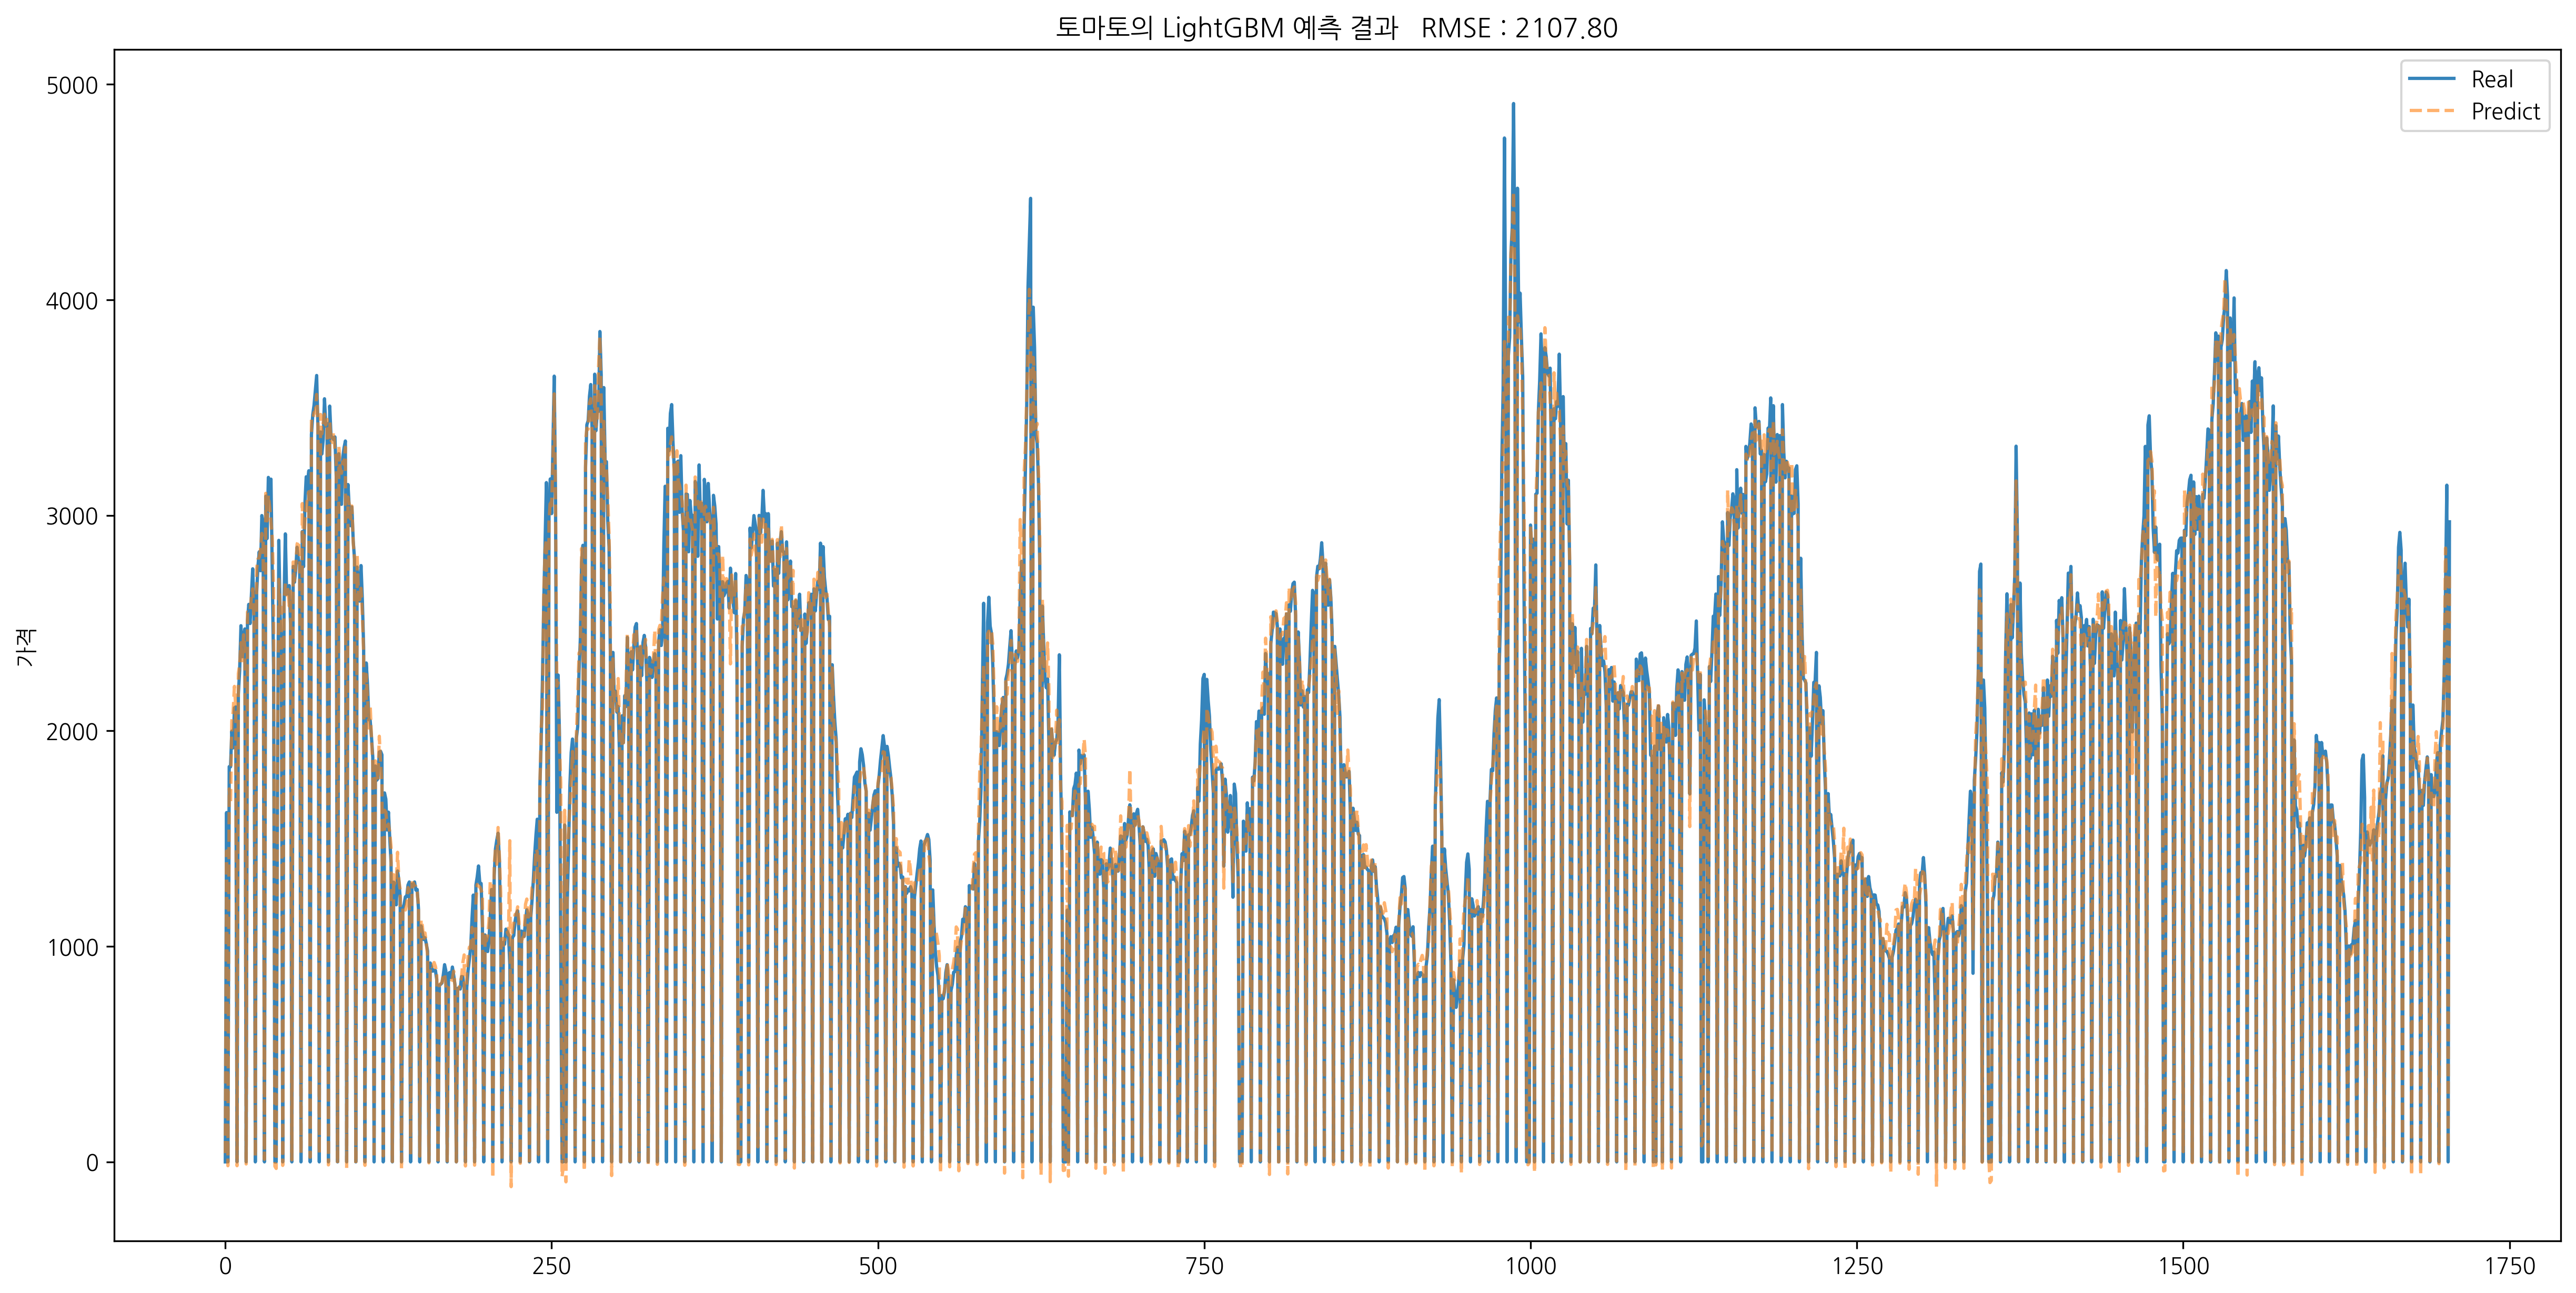

In [103]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('토마토의 LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

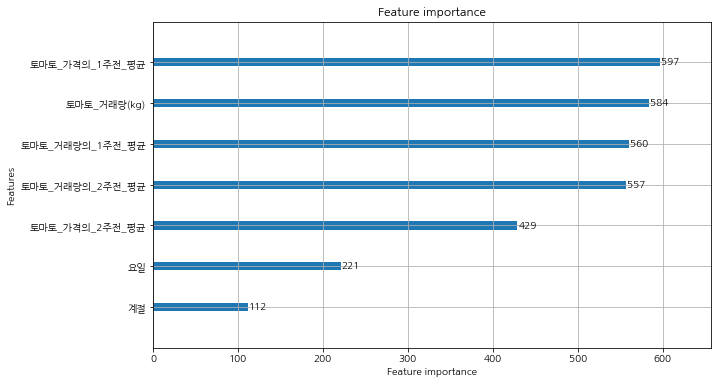

In [104]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [88]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: ignored

In [89]:
## 모델 예측

x_test = np.array([[370000, 20000]])### 모델의 예측 결과
#전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

#큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

#[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 1245.657197370245 
confidence : 1117.20627282996
ratio : 1.11


## 2. 샤인마스캇

In [105]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['샤인마스캇_거래량(kg)','샤인마스캇_거래량의_1주전_평균','샤인마스캇_가격의_1주전_평균','샤인마스캇_거래량의_2주전_평균','샤인마스캇_가격의_2주전_평균','계절','요일']]
target = df['샤인마스캇_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 7) (1705,) (28, 7) (28,) (37, 7) (37,)


In [106]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [107]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [108]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 894.711
Early stopping, best iteration is:
[32]	valid_0's l1: 839.185


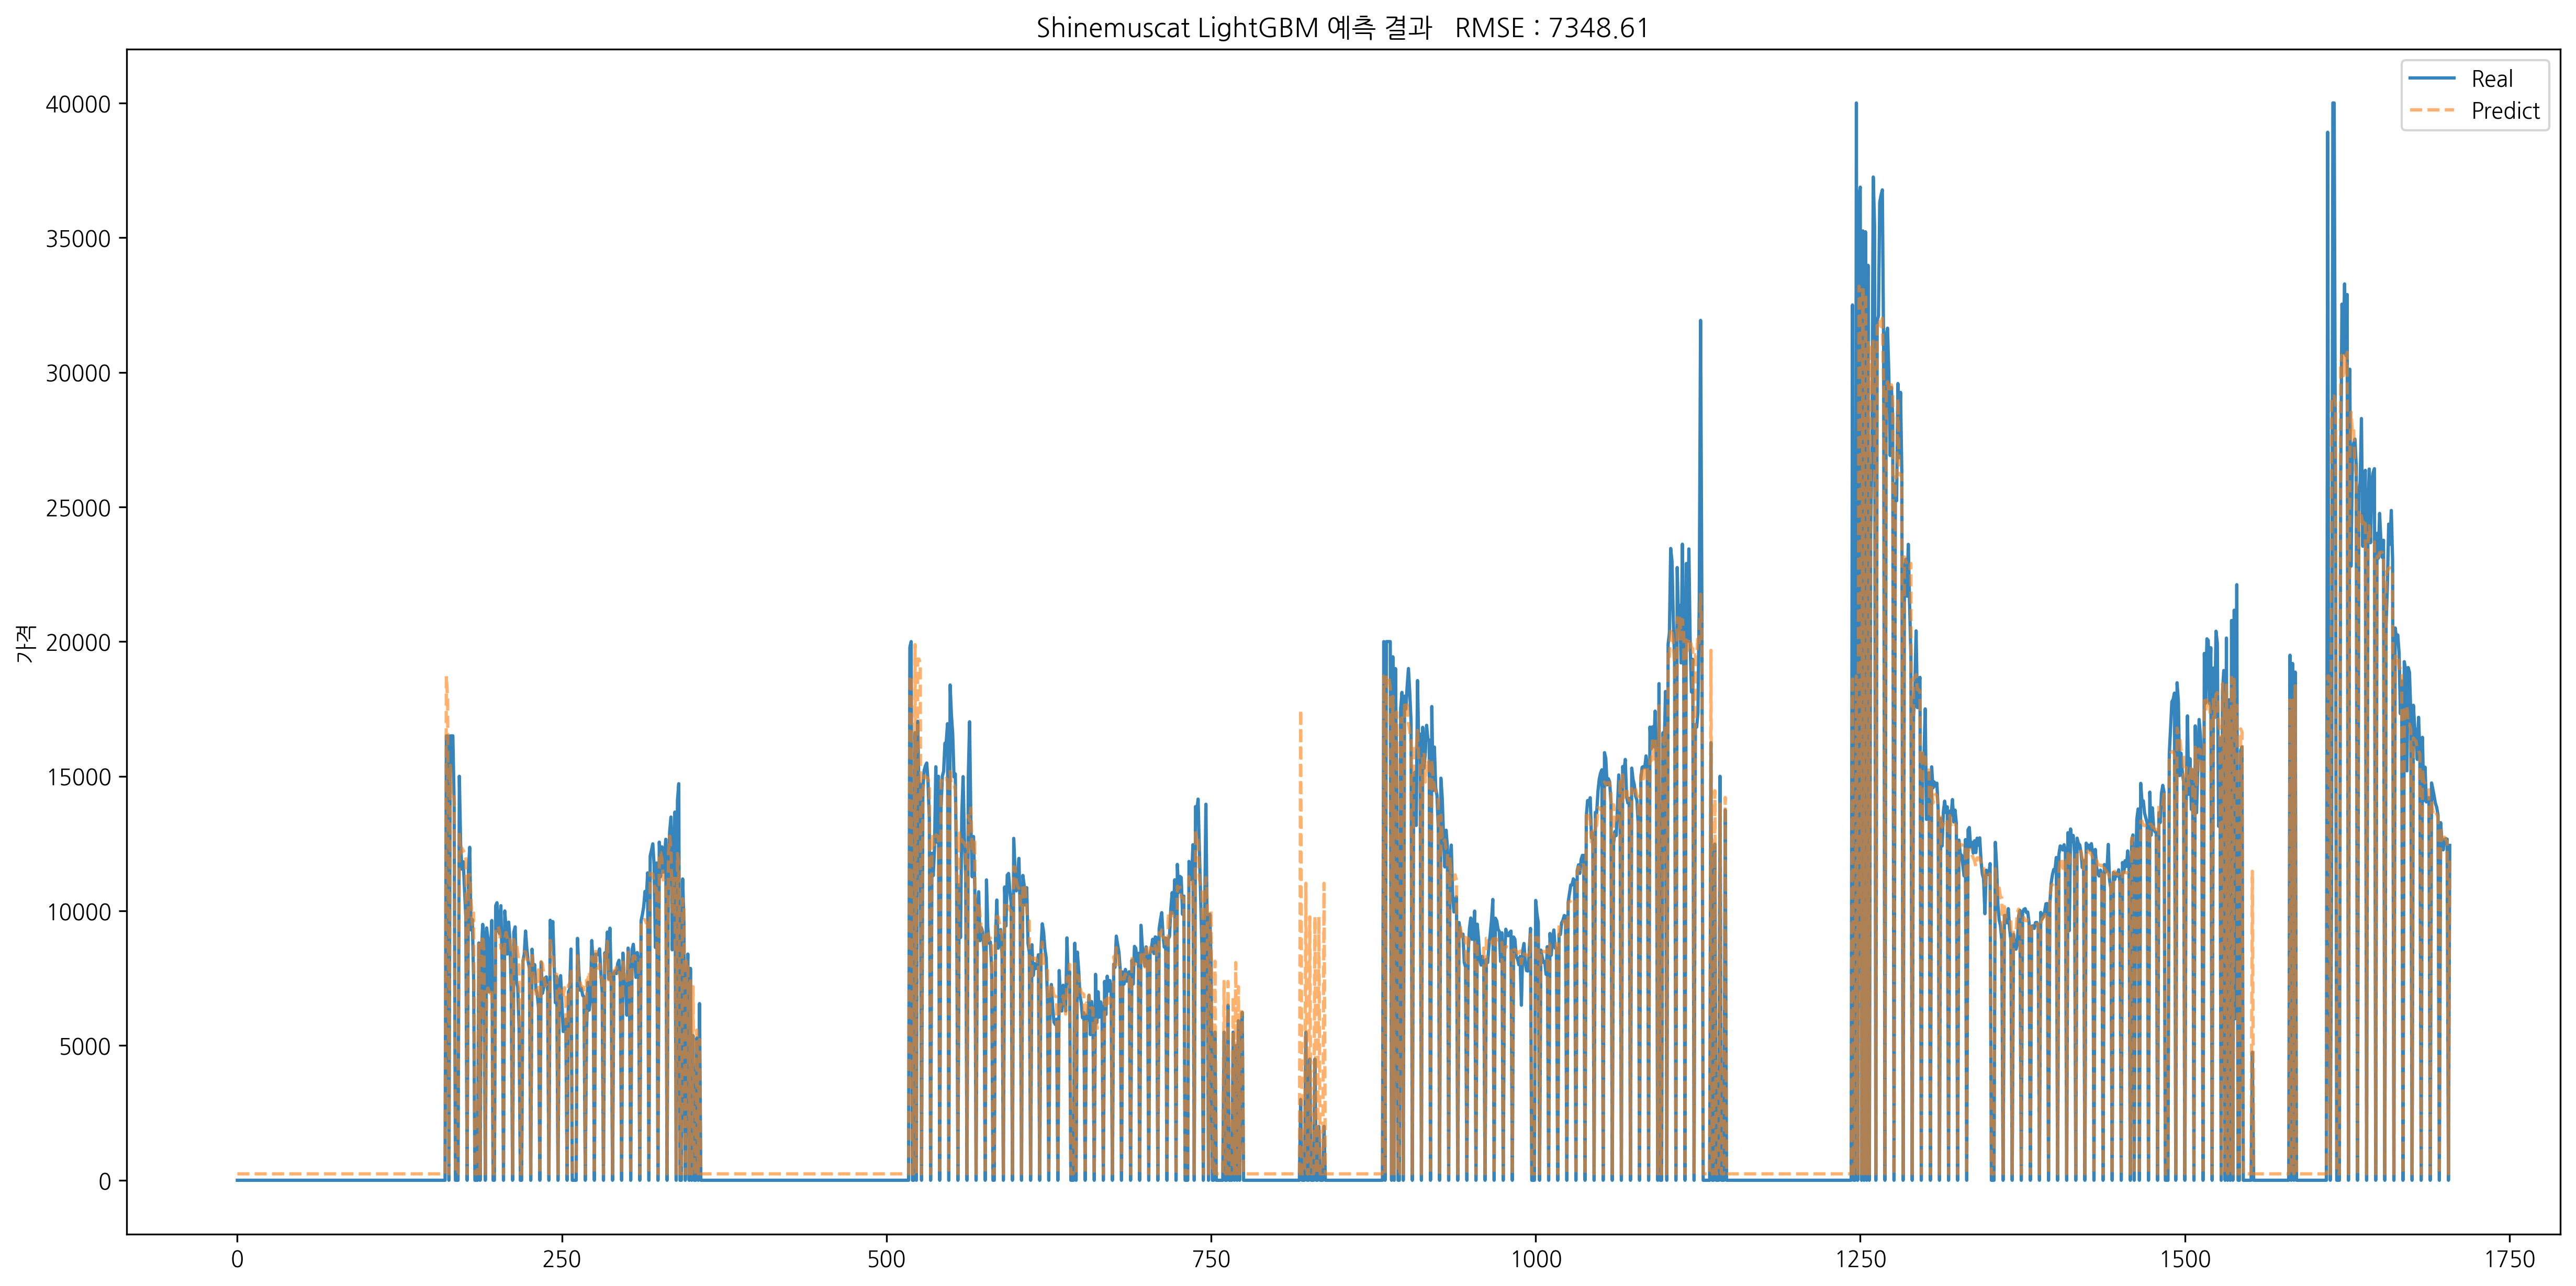

In [109]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

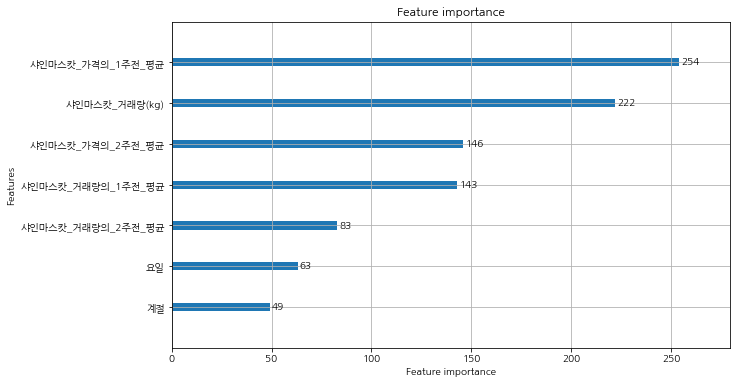

In [110]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [ ]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: 'Booster' object has no attribute 'score'

In [111]:
## 모델 예측

x_test = np.array([[20000, 3000]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 17827.41165978612 
confidence : 8146.629891768611
ratio : 2.19


## 3.캠벨얼리

In [112]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['캠벨얼리_거래량(kg)','캠벨얼리_거래량의_1주전_평균','캠벨얼리_가격의_1주전_평균','캠벨얼리_거래량의_2주전_평균','캠벨얼리_가격의_2주전_평균','계절','요일']]
target = df['캠벨얼리_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 7) (1705,) (28, 7) (28,) (37, 7) (37,)


In [113]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [114]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [115]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 317.413
Early stopping, best iteration is:
[32]	valid_0's l1: 308.816


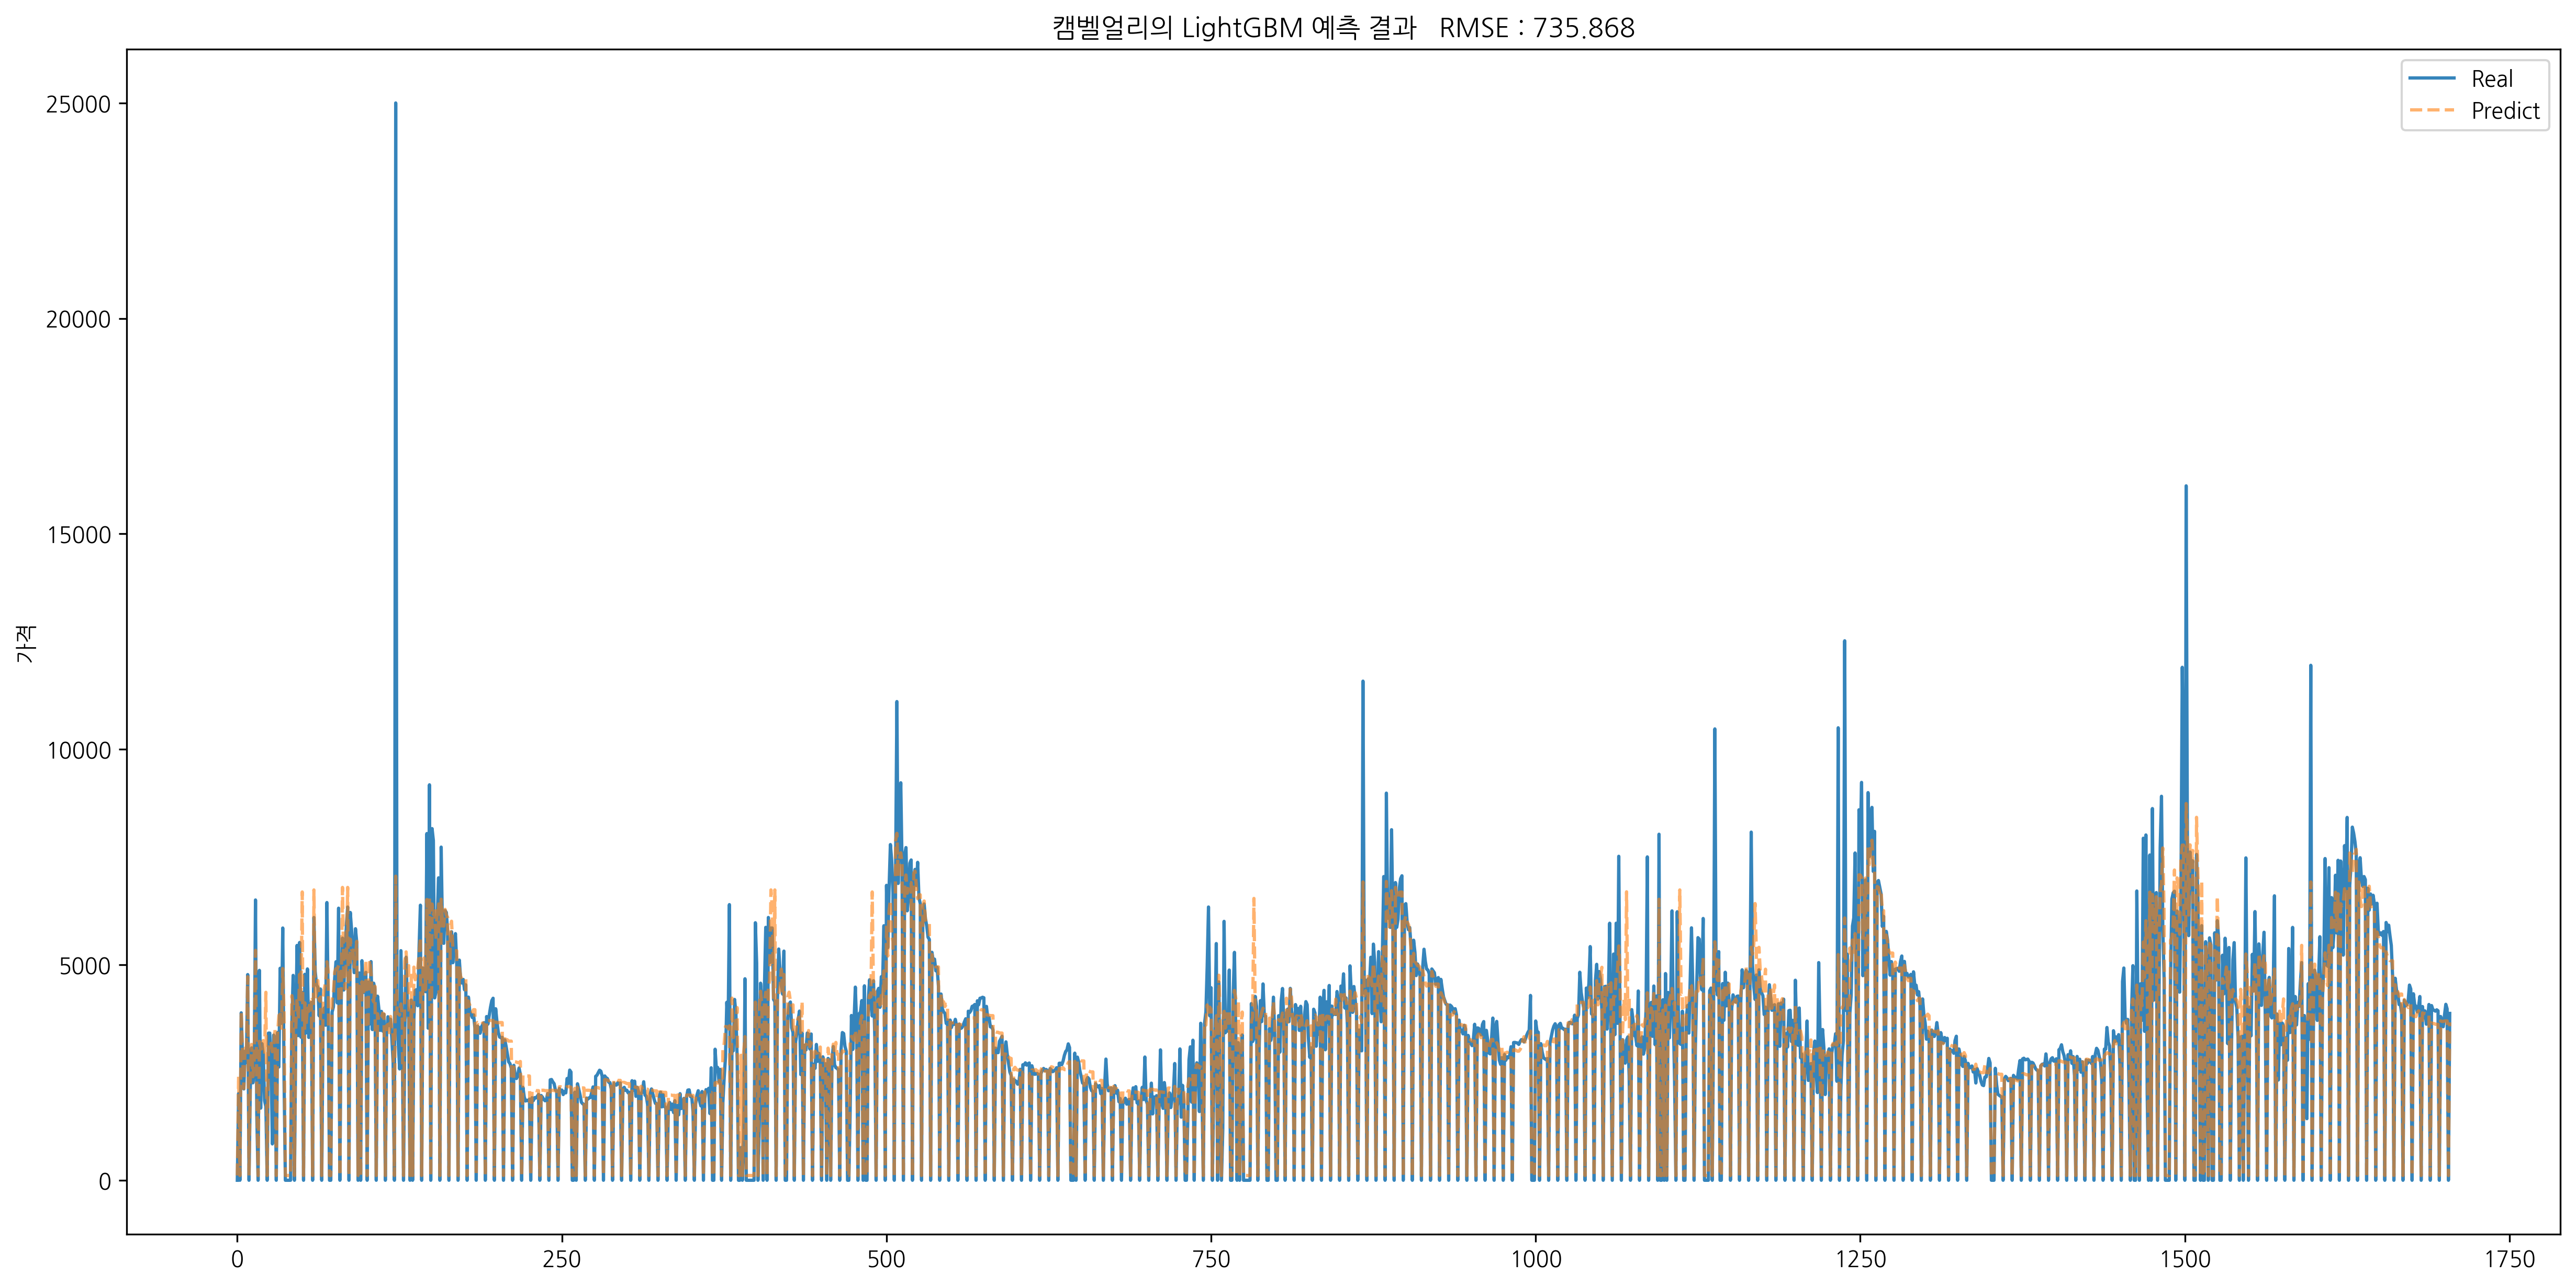

In [117]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('캠벨얼리의 LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

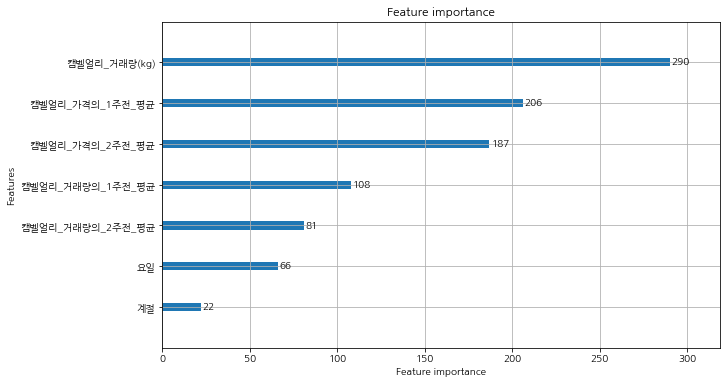

In [118]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [119]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: ignored

In [ ]:
## 모델 예측

x_test = np.array([[20000, 3000]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

## 4. 깻잎

In [120]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['깻잎_거래량(kg)','깻잎_거래량의_1주전_평균','깻잎_가격의_1주전_평균','깻잎_거래량의_2주전_평균','깻잎_가격의_2주전_평균','계절','요일']]
target = df['깻잎_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 7) (1705,) (28, 7) (28,) (37, 7) (37,)


In [121]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [122]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [123]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2173.55
Early stopping, best iteration is:
[38]	valid_0's l1: 2099.46


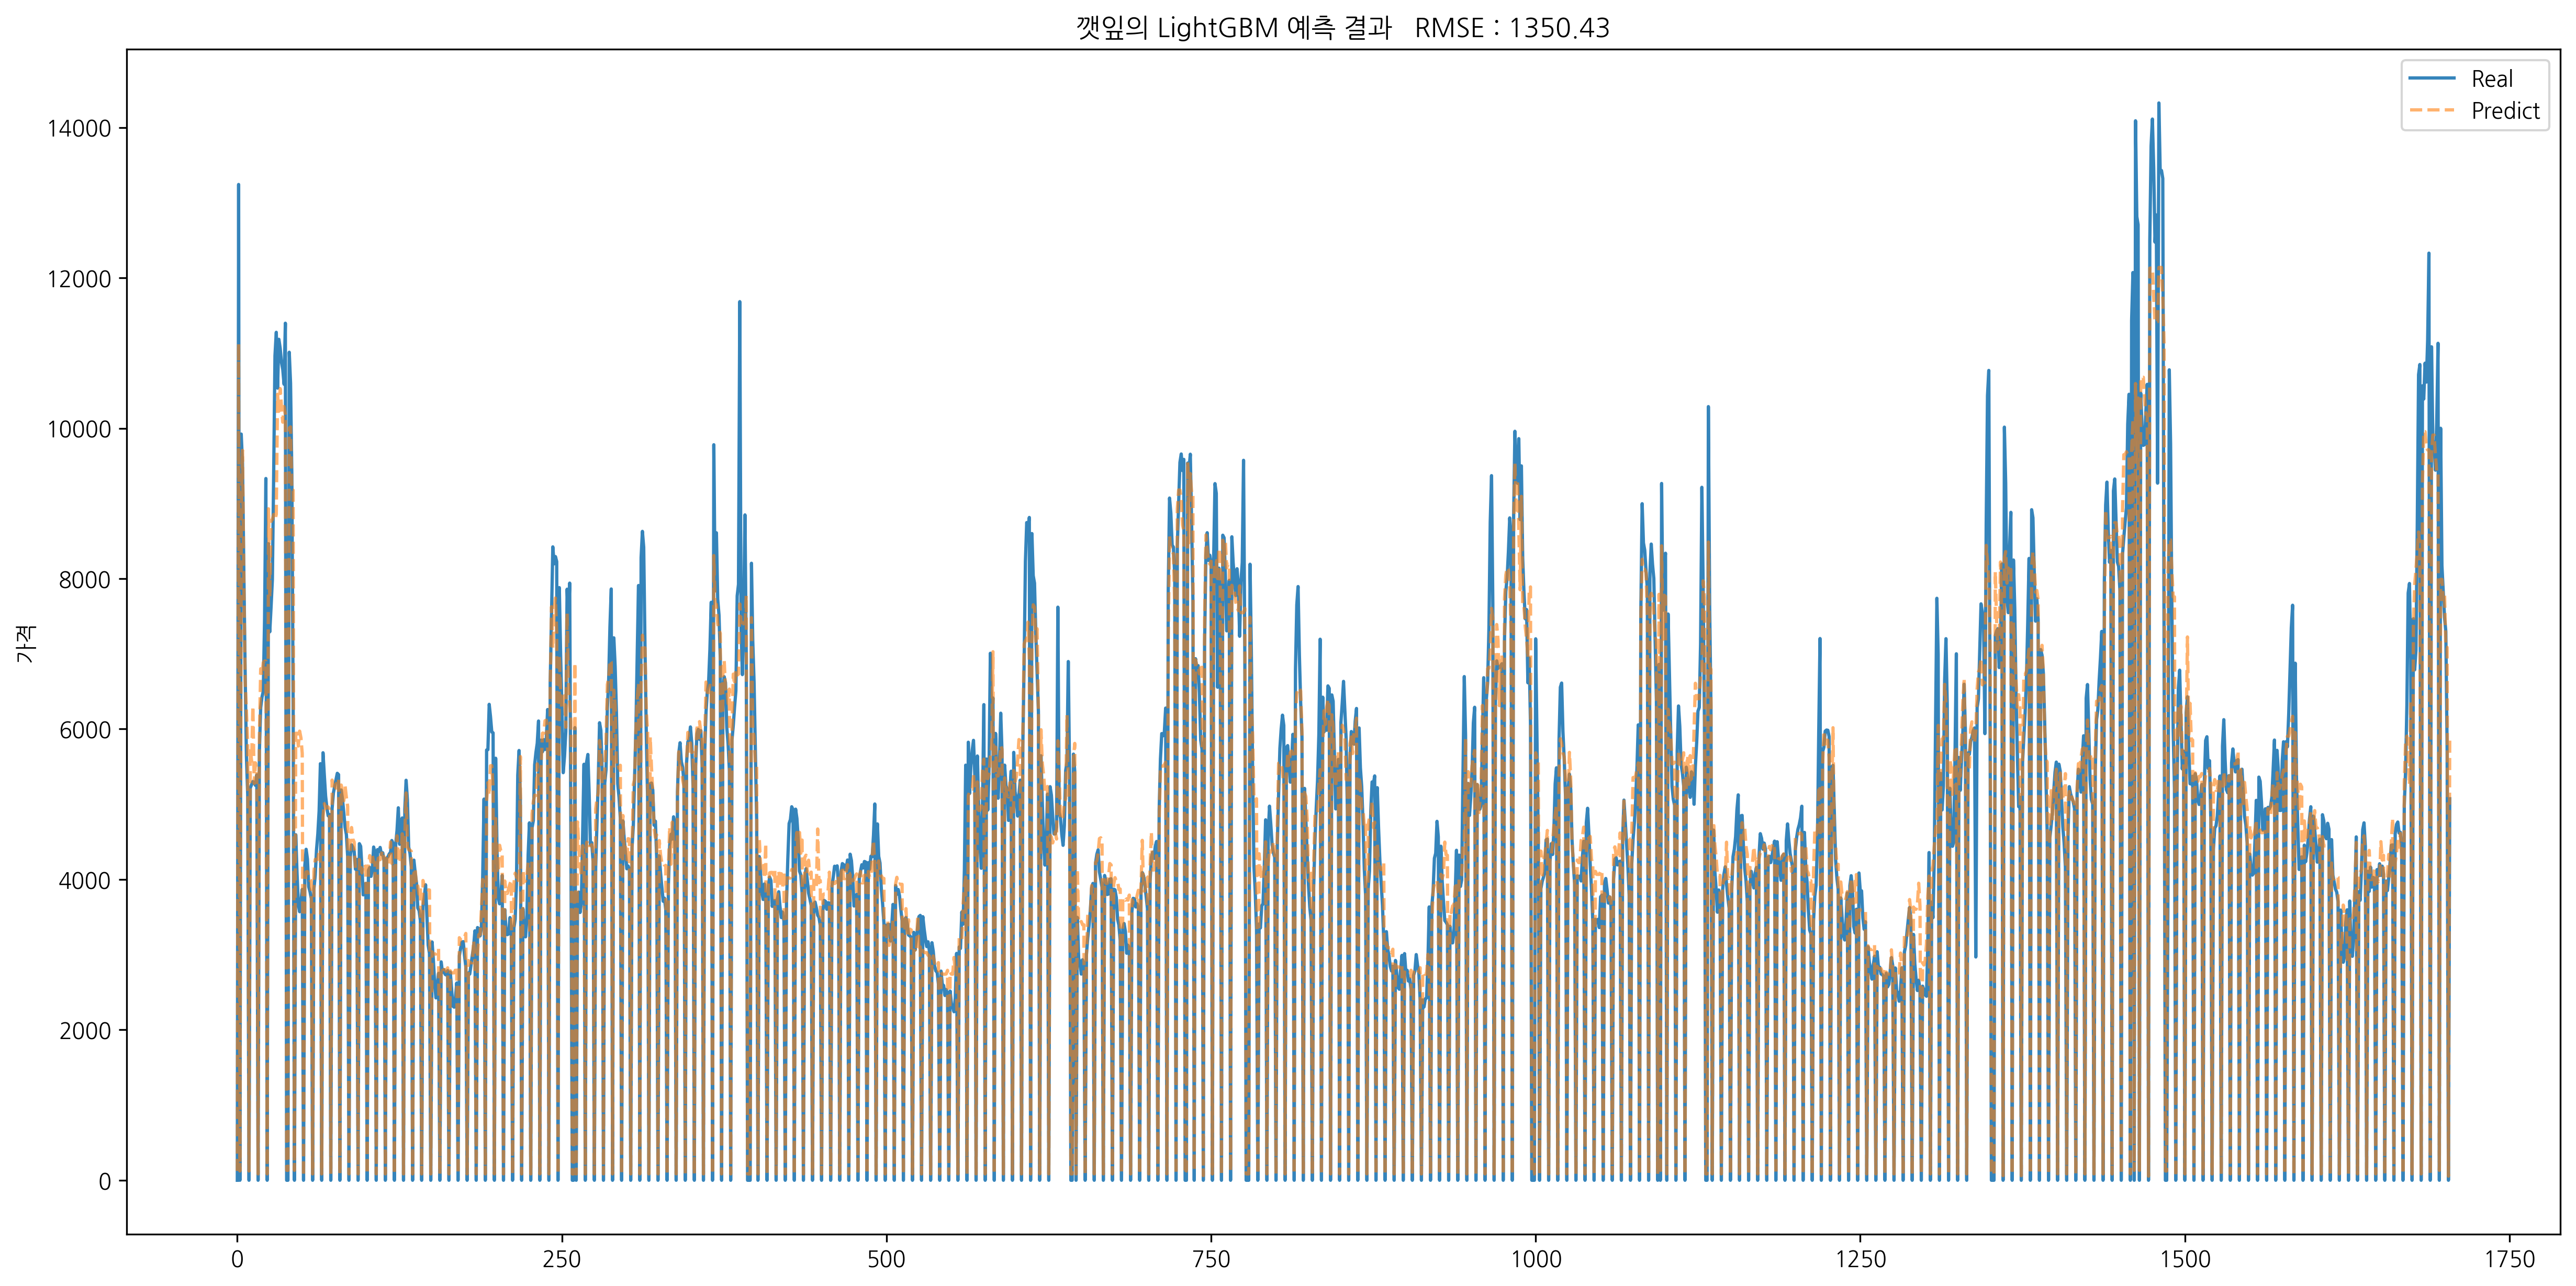

In [125]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('깻잎의 LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

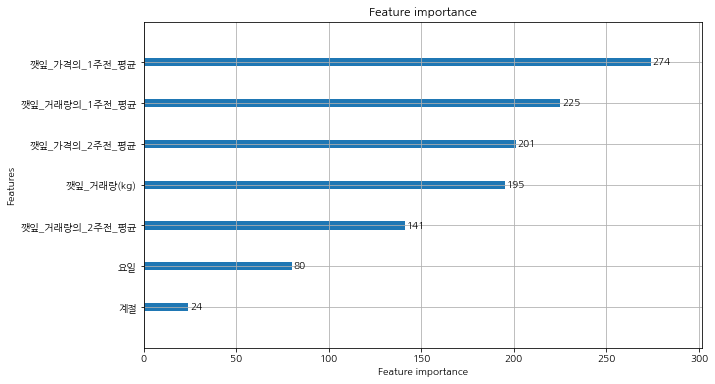

In [126]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [127]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: ignored

In [128]:
## 모델 예측

x_test = np.array([[20000, 3000]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 4359.895772911996 
confidence : 5221.0972231209225
ratio : 0.84


## 5. 대파

In [129]:
# train 20190101 ~ 20200831 / valid   20200901 ~ 20200928 / test 20200929 ~ 20201104

train_split = 1705
valid_split = 1733

feature = df[['대파_거래량(kg)','대파_거래량의_1주전_평균','대파_가격의_1주전_평균','대파_거래량의_2주전_평균','대파_가격의_2주전_평균','계절','요일']]
target = df['대파_가격(원/kg)']

X_train = feature[:train_split]
y_train = target[:train_split]

X_valid = feature[train_split:valid_split]
y_valid = target[train_split:valid_split]

X_test = feature[valid_split:]
y_test = target[valid_split:]

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape,X_test.shape, y_test.shape)

(1705, 7) (1705,) (28, 7) (28,) (37, 7) (37,)


In [130]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [131]:
train_ds = lgb.Dataset(X_train,  label = y_train)
val_ds = lgb.Dataset(X_valid,  label = y_valid)

In [132]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_ds,
                   1000,
                   val_ds,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 388.468
Early stopping, best iteration is:
[42]	valid_0's l1: 377.585


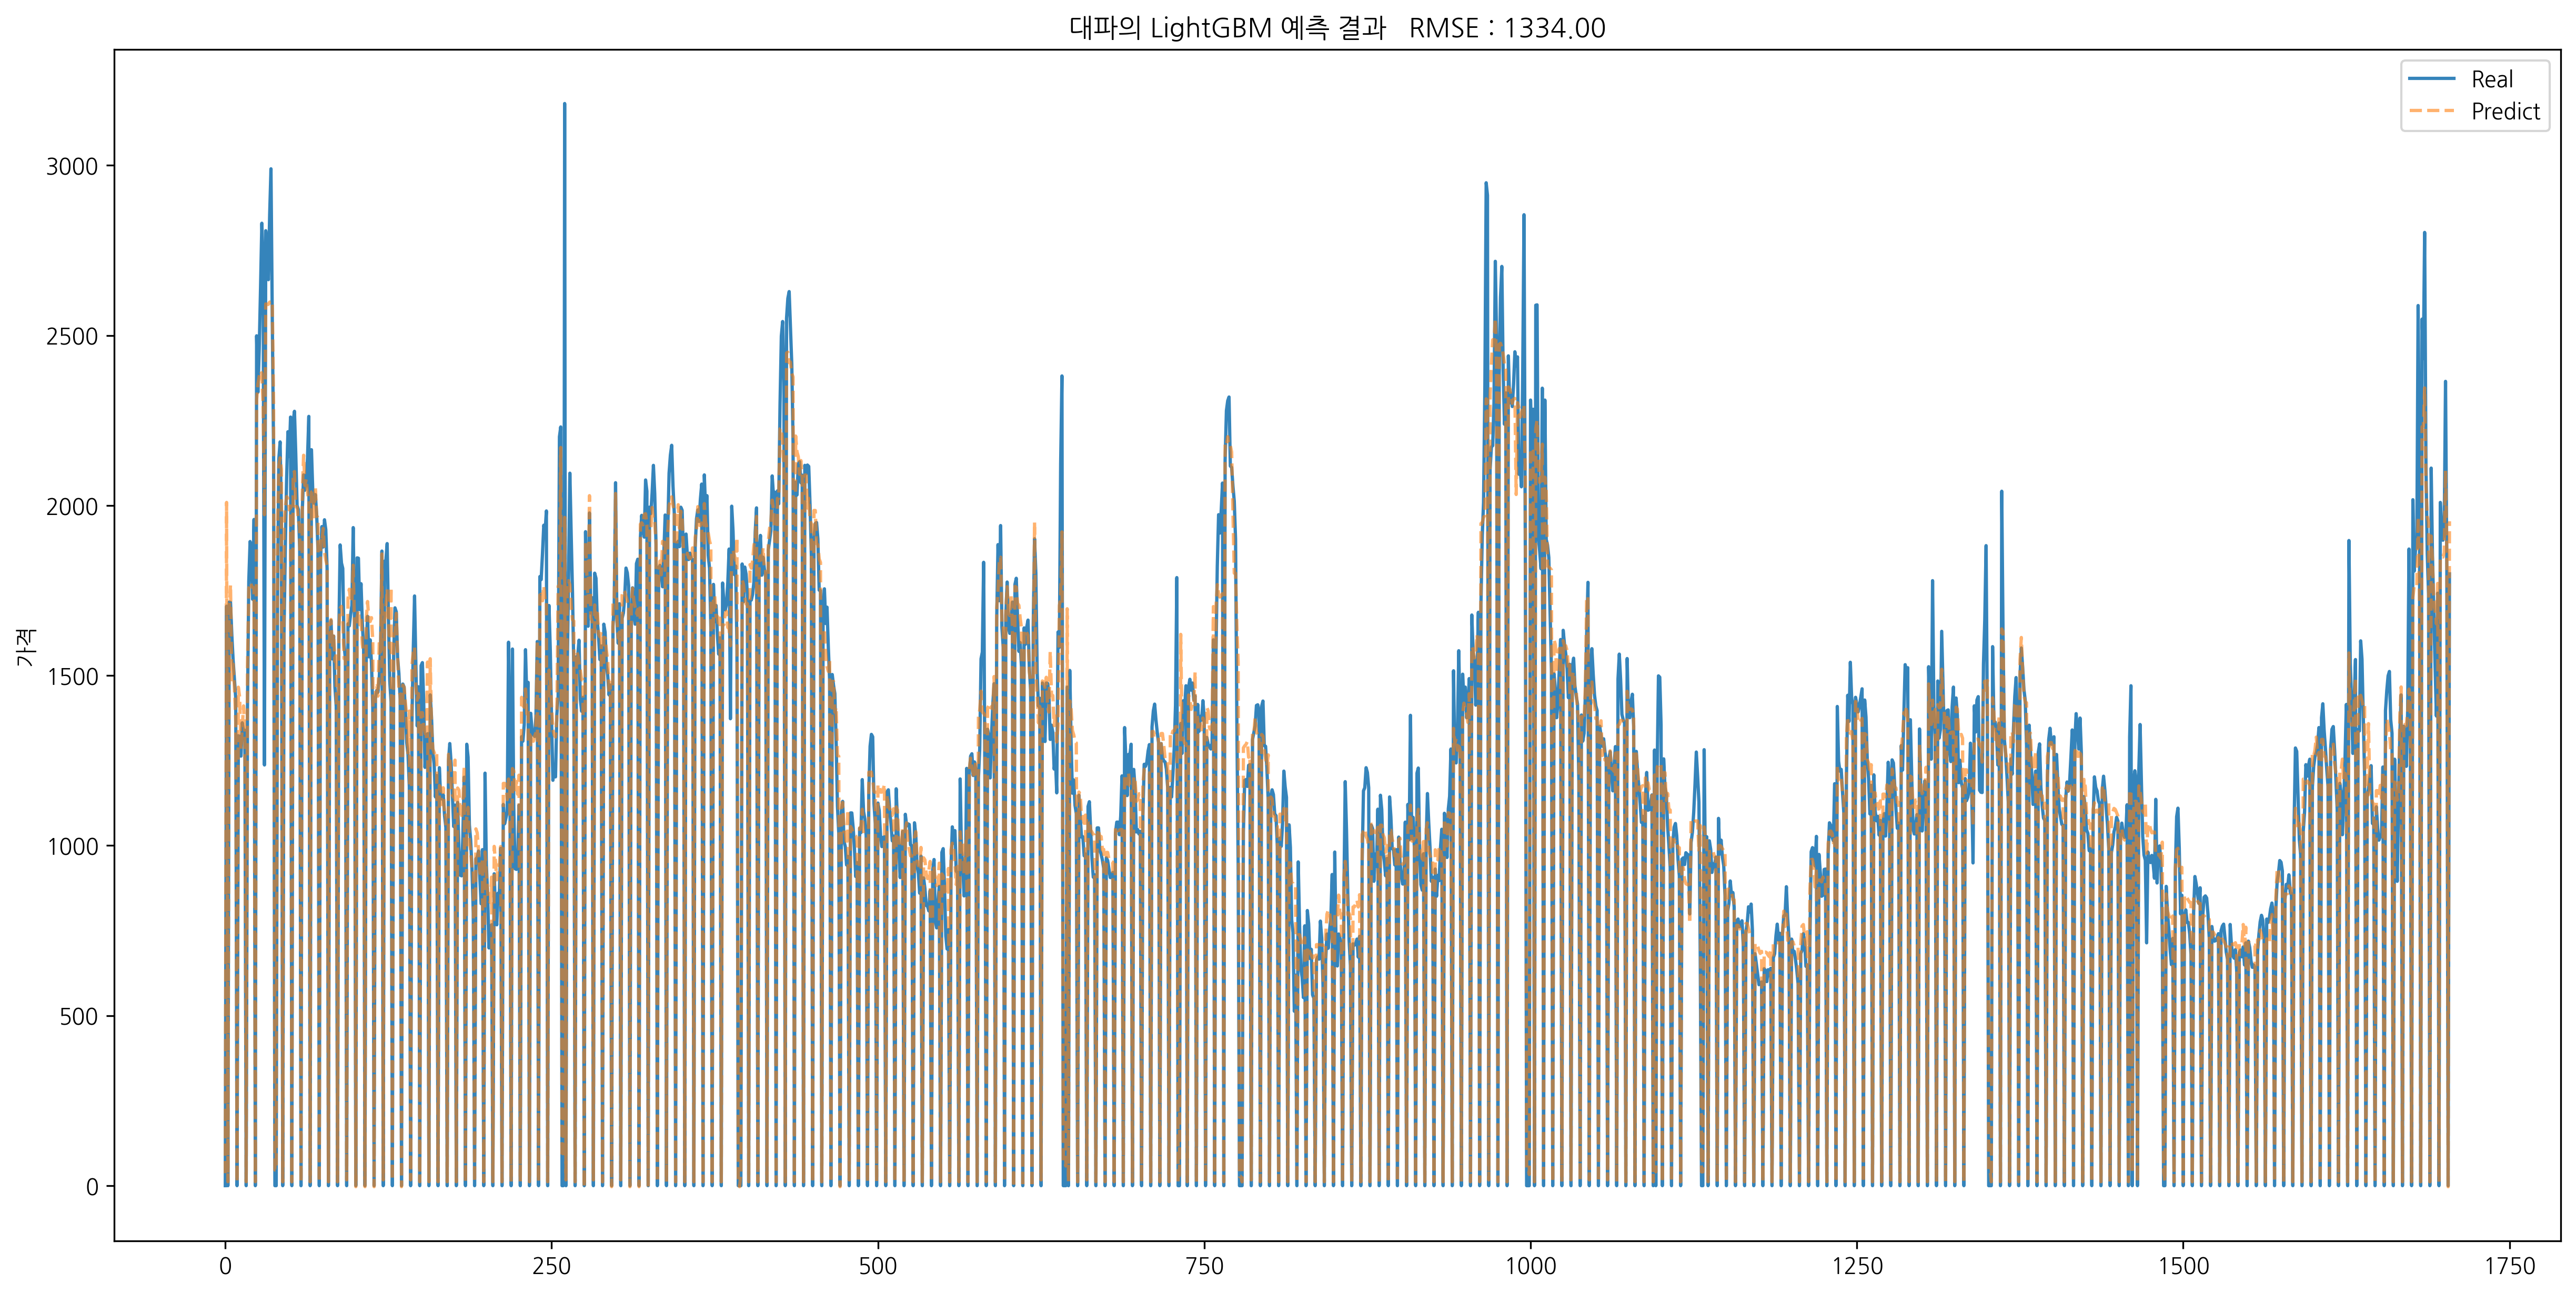

In [133]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('대파의 LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

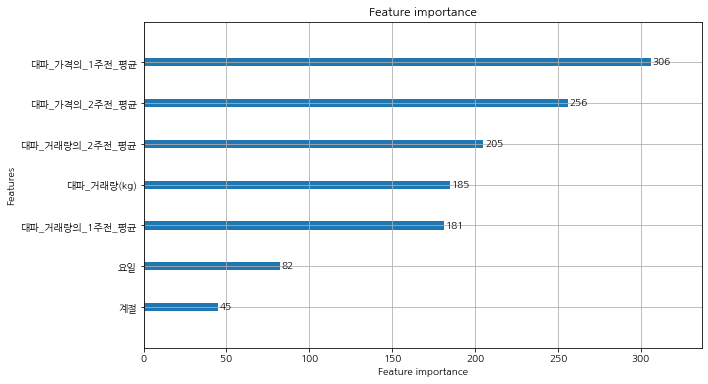

In [134]:
# importance
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))
plot_importance(model, ax = ax)

In [ ]:
## 모델 검증(accuracy_score)

print(f'X_train accuracy_score : {model.score(X_train, y_train)}')
print(f'X_test accuracy_score : {model.score(X_valid, y_valid)}')

AttributeError: 'Booster' object has no attribute 'score'

In [135]:
## 모델 예측

x_test = np.array([[20000, 3000]])

label = y_pred[0]
y_predict = model.predict(x_test)
confidence = y_predict[0]

print(f'label : {label} \nconfidence : {confidence}\nratio : {round(label/confidence, 2)}' )

label : 917.4372218886941 
confidence : 955.6879151139934
ratio : 0.96


# LSTM 모델링

# Prophet 
